# Part 1: Data Analysis
## Chapter 2: Financial Data Structure

In [2]:
import gc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm
from utils import imbalance_dollar_bar, reduce_memory_usage, load_df

def plot_autocorr(title: str, bar_return: np.ndarray, ax):
    sm.graphics.tsa.plot_acf(bar_return, lags=120, ax=ax,
                             alpha=0.05, unbiased=True, fft=True,
                             zero=False, auto_ylims=True,
                             title=title)
    
    plt.tight_layout()  

def returns(prices):
    return prices.pct_change().dropna()

def serial_correlation(returns):
    return returns.autocorr()

In [5]:
dates = ['2024-03', '2024-04', '2024-05']
btc_transactions = reduce_memory_usage(
    pd.concat([
        load_df(f"Advances-In-Financial-Machine-Learning\data\BTCUSDT-trades-{date}.csv")
        for date in dates
    ])
)

Memory usage of dataframe is 3671.92 MB
Memory usage after optimization is: 2447.95 MB
Decreased by 33.3%
Memory usage of dataframe is 3093.14 MB
Memory usage after optimization is: 2062.09 MB
Decreased by 33.3%


KeyboardInterrupt: 

### 2.1 On a series of E-mini S&P 500 futures tick data: (I'll use BTC)

#### (a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.


In [86]:
def create_time_bars(transaction_df, T):
    # Convert epoch timestamp to datetime
    transaction_df['dt_time'] = pd.to_datetime(transaction_df['time'], unit='ms')
    transaction_df.set_index('dt_time', inplace=True)
    
    # Resample the dataframe to create bars for every T minutes
    if T[-1] == 'm':
        T = T[:-1] + 'min'
    resampled_df = transaction_df.resample(T).agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'
    })
    
    resampled_df.columns = ['open', 'high', 'low', 'close', 'volume']
    resampled_df.dropna(inplace=True)
    resampled_df.reset_index(inplace=True)
    resampled_df['time'] = resampled_df['dt_time']
    del resampled_df['dt_time']
    gc.collect()
    
    return resampled_df

def create_tick_bars(transaction_df, T):
    transaction_df = transaction_df.sort_values(by='time').reset_index(drop=True)
    n_bars = len(transaction_df) // T
    transactions = transaction_df.iloc[:n_bars * T]
    chunks = transactions.values.reshape(n_bars, T, -1)
    times = chunks[:, :, transaction_df.columns.get_loc('time')]
    prices = chunks[:, :, transaction_df.columns.get_loc('price')]
    qtys = chunks[:, :, transaction_df.columns.get_loc('qty')]
    
    times_end = times[:, -1]
    opens = prices[:, 0]
    highs = prices.max(axis=1)
    lows = prices.min(axis=1)
    closes = prices[:, -1]
    volumes = qtys.sum(axis=1)
    
    tick_bars_df = pd.DataFrame({
        'time': times_end,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    })
    
    return reduce_memory_usage(tick_bars_df)



def create_volume_bars(transaction_df, T):
    transaction_df = transaction_df.sort_values(by='time').reset_index(drop=True)
    transaction_df['cumulative_volume'] = transaction_df['qty'].cumsum()
    # Identify the indices where the cumulative volume reaches the threshold T
    volume_thresholds = np.arange(T, transaction_df['cumulative_volume'].max(), T)
    volume_bar_indices = np.searchsorted(transaction_df['cumulative_volume'].values, volume_thresholds)
    
    times = []
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    previous_index = 0
    for index in volume_bar_indices:
        if previous_index != index:
            chunk = transaction_df.iloc[previous_index:index]
        times.append(chunk['time'].iloc[-1])
        opens.append(chunk['price'].iloc[0])
        highs.append(chunk['price'].max())
        lows.append(chunk['price'].min())
        closes.append(chunk['price'].iloc[-1])
        volumes.append(chunk['qty'].sum())
        previous_index = index
    
    volume_bars_df = pd.DataFrame({
        'time': times,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    })
    
    return reduce_memory_usage(volume_bars_df)

def create_dollar_bars(transaction_df, T):
    transaction_df = transaction_df.sort_values(by='time').reset_index(drop=True)
    transaction_df['cumulative_dollar'] = (transaction_df['price']*transaction_df['qty']).cumsum()
    # Identify the indices where the cumulative volume reaches the threshold T
    volume_thresholds = np.arange(T, transaction_df['cumulative_dollar'].max(), T)
    volume_bar_indices = np.searchsorted(transaction_df['cumulative_dollar'].values, volume_thresholds)
    
    times = []
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    previous_index = 0
    for index in volume_bar_indices:
        if previous_index != index:
            chunk = transaction_df.iloc[previous_index:index]
        times.append(chunk['time'].iloc[-1])
        opens.append(chunk['price'].iloc[0])
        highs.append(chunk['price'].max())
        lows.append(chunk['price'].min())
        closes.append(chunk['price'].iloc[-1])
        volumes.append(chunk['qty'].sum())
        previous_index = index
    
    dollar_bars_df = pd.DataFrame({
        'time': times,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    })
    
    dollar_bars_df = dollar_bars_df.groupby('time').agg({
        'open': 'first',
        'close': 'last',
        'high': 'max',
        'low': 'min',
        'volume': 'sum'
    }).reset_index()
    
    return reduce_memory_usage(dollar_bars_df)

In [80]:

btc_ticks = create_tick_bars(btc_transactions, 1000)
btc_volume = create_volume_bars(btc_transactions, 100)
btc_dollar = create_dollar_bars(btc_transactions, 1e7)
gc.collect()


Memory usage of dataframe is 3.01 MB
Memory usage after optimization is: 3.01 MB
Decreased by 0.0%


256

#### (b) Count the number of bars produced by tick

In [48]:
def count_samples(df, T):
    if T[-1] == 'm':
        T = T[:-1] + 'min'
    df['dt_time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('dt_time', inplace=True)
    resampled_df = df.resample(T).size()
    resampled_df = resampled_df.reset_index(name='count')
    df.reset_index(inplace=True)
    resampled_df['time'] = resampled_df['dt_time']
    del resampled_df['dt_time']
    
    return resampled_df

Text(0.5, 1.0, 'BTC moving avg bars per hour')

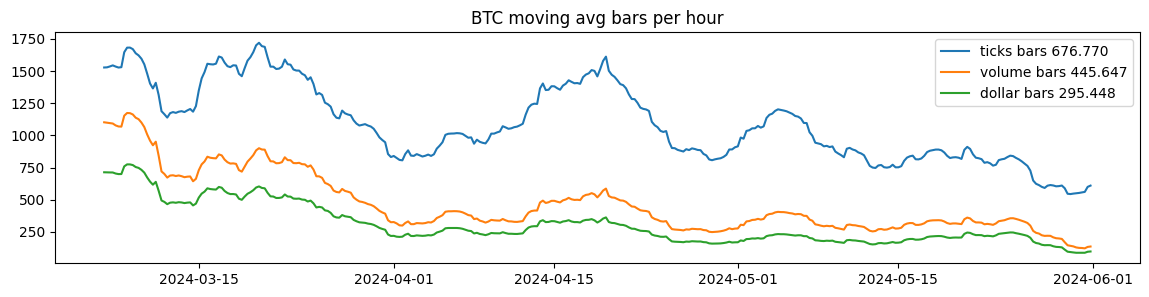

In [81]:
plt.figure(figsize=(14, 3))
count_times = count_samples(btc_ticks, '6h')
plt.plot(count_times['time'], count_times['count'].rolling(window=24).mean(), label=f'ticks bars {np.std(count_times["count"]):.3f}')

count_times = count_samples(btc_volume, '6h')
plt.plot(count_times['time'], count_times['count'].rolling(window=24).mean(), label=f'volume bars {np.std(count_times["count"]):.3f}')

count_times = count_samples(btc_dollar, '6h')
plt.plot(count_times['time'], count_times['count'].rolling(window=24).mean(), label=f'dollar bars {np.std(count_times["count"]):.3f}')
plt.legend(loc='best')
plt.title("BTC moving avg bars per hour")

The windows that im using for each bar is arbitrary and its only 1 month of data but,
`tick bars` has a big variance because every single little trade raise a transaction
`volume bars` is the number of coins that is transfer and is very affected by price of the symbol
`dollar bars` the most stable because its the amount of money that traded, and it represents the actual liquidity of the symbol

#### (c) Serial correlation of returns

In [82]:
print(f'Ticks bars serial correlation {serial_correlation(returns(btc_ticks["close"]))}')
print(f'Volume bars serial correlation {serial_correlation(returns(btc_volume["close"]))}')
print(f'Dollar bars serial correlation {serial_correlation(returns(btc_dollar["close"]))}')

Ticks bars serial correlation 0.015067275411174027
Volume bars serial correlation -0.011316380263760414
Dollar bars serial correlation -0.005729529805330345


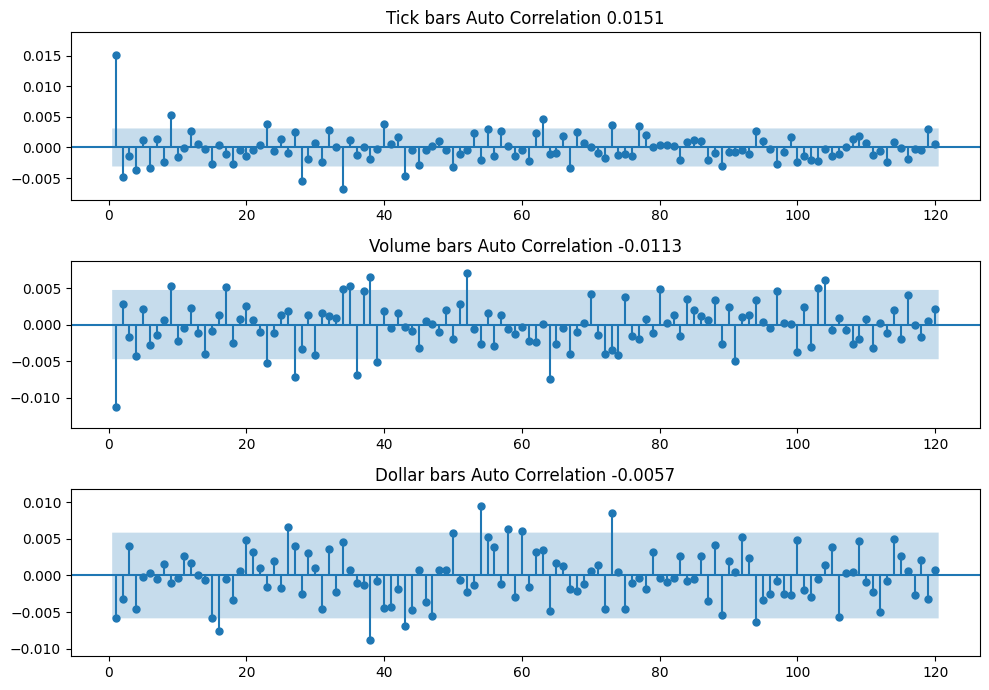

In [74]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
plot_autocorr(f'Tick bars Auto Correlation {serial_correlation(returns(btc_ticks["close"])):.4f}',
              returns(btc_ticks["close"]), axs[0])
plot_autocorr(f'Volume bars Auto Correlation {serial_correlation(returns(btc_volume["close"])):.4f}',
              returns(btc_volume["close"]), axs[1])
plot_autocorr(f'Dollar bars Auto Correlation {serial_correlation(returns(btc_dollar["close"])):.4f}',
              returns(btc_dollar["close"]), axs[2])

#### (d) compute the variance for every month (ill do it for every day)

Text(0.5, 1.0, 'BTC variance per week')

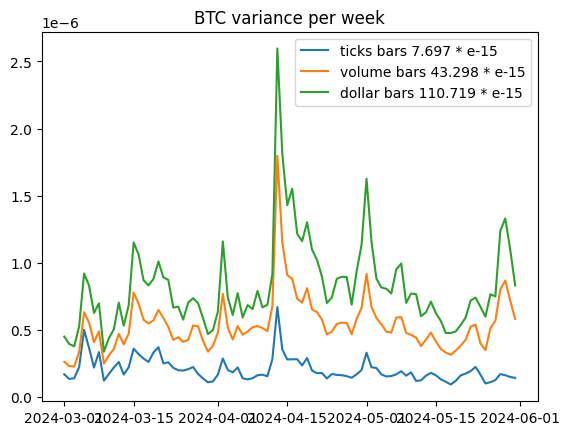

In [9]:
def rolling_variance(df: pd.DataFrame, T: str):
    df['dt_time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('dt_time', inplace=True)
    variance_df = returns(df['close']).resample(T).var().reset_index()
    variance_df.columns = ['time', 'variance']
    df.reset_index(inplace=True, drop=True)
    return variance_df

rolling_variance_ticks = rolling_variance(btc_ticks, '1D')
rolling_variance_volume = rolling_variance(btc_volume, '1D')
rolling_variance_dollar = rolling_variance(btc_dollar, '1D')


plt.plot(rolling_variance_ticks['time'], rolling_variance_ticks['variance'], label=f'ticks bars {np.var(rolling_variance_ticks["variance"])*1e15:.3f} * e-15')
plt.plot(rolling_variance_volume['time'], rolling_variance_volume['variance'], label=f'volume bars {np.var(rolling_variance_volume["variance"])*1e15:.3f} * e-15')
plt.plot(rolling_variance_dollar['time'], rolling_variance_dollar['variance'], label=f'dollar bars {np.var(rolling_variance_dollar["variance"])*1e15:.3f} * e-15')
plt.legend(loc='best')
plt.title("BTC variance per week")

tick bars exhibit the smallest variance of variances, as for dollar / volume bars the more money that moves than the prices change as well.

#### (d) apply Jarque-Bera normality test

In [10]:
from scipy.stats import jarque_bera

jb_ticks, p_value_ticks = jarque_bera(returns(btc_ticks['close']))
jb_volume, p_value_volume = jarque_bera(returns(btc_volume['close']))
jb_dollar, p_value_dollar = jarque_bera(returns(btc_dollar['close']))

print(f'Ticks bar Jarque-Bera test: {jb_ticks, p_value_ticks}')
print(f'Volume bar Jarque-Bera test: {jb_volume, p_value_volume}')
print(f'Dollar bar Jarque-Bera test: {jb_dollar, p_value_dollar}')

Ticks bar Jarque-Bera test: (308022.8037118264, 0.0)
Volume bar Jarque-Bera test: (59912.73255180596, 0.0)
Dollar bar Jarque-Bera test: (14869.69861928461, 0.0)


Dollar bar has the smallest Jarque-Bera test statistics even though all of the bars get a p_value of 0 

In [11]:
# no need for these arrays anymore
del btc_ticks
del btc_volume
gc.collect()

0

### 2.2 Dollar bars & Dollars imbalance bars

In [4]:
btc_imbalance_dollar_bar = imbalance_dollar_bar(btc_transactions['price'].values,
                           btc_transactions['qty'].values, )

len(btc_imbalance_dollar_bar[0,:])

# to make it dataframe and not ndarray
# btc_imbalance_dollar_bar[0, :] += btc_transactions['time'].iloc[btc_imbalance_dollar_bar[0, :]]
# btc_imbalance_dollar_bar = pd.DataFrame(btc_imbalance_dollar_bar.T, columns=['time', 'open', 'close', 'high', 'low', 'volume', 'dollars'])
# btc_imbalance_dollar_bar['time'] = pd.to_datetime(btc_imbalance_dollar_bar['time'], unit='ms')

NameError: name 'btc_transactions' is not defined

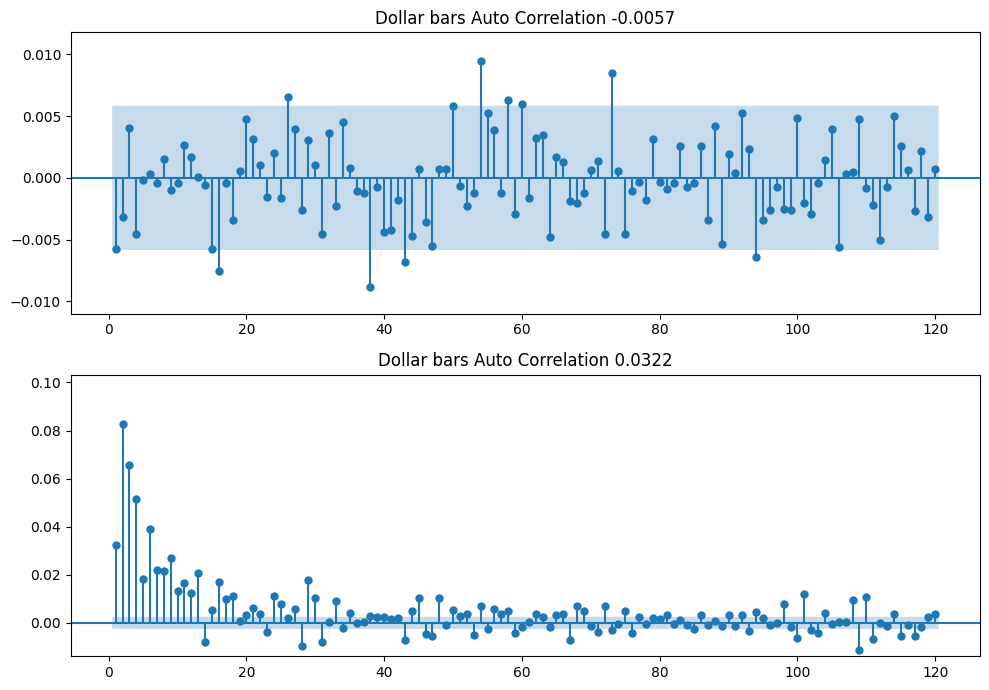

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
plot_autocorr(f'Dollar bars Auto Correlation {serial_correlation(returns(btc_dollar["close"])):.4f}',
              returns(btc_dollar["close"]), axs[0])
plot_autocorr(f'Dollar bars Auto Correlation {serial_correlation(returns(pd.Series(btc_imbalance_dollar_bar[2, :]))):.4f}',
              returns(pd.Series(btc_imbalance_dollar_bar[2, :])), axs[1])

In [ ]:
del btc_imbalance_dollar_bar
del btc_dollar
del btc_transactions
gc.collect()

### 2.3 ETF Trick on multiple assets

#### Apply PCA on dollar bar on the assets

In [6]:
btc_transactions = load_df(f"Advances-In-Financial-Machine-Learning\data\BTCUSDT-trades-2024-05.csv")
eth_transactions = load_df(f"Advances-In-Financial-Machine-Learning\data\ETHUSDT-trades-2024-05.csv")

Memory usage of dataframe is 2326.83 MB
Memory usage after optimization is: 1551.22 MB
Decreased by 33.3%
Memory usage of dataframe is 2712.79 MB
Memory usage after optimization is: 1808.53 MB
Decreased by 33.3%


In [27]:
btc_dollar_bar = create_dollar_bars(btc_transactions, int(2e7))
eth_dollar_bar = create_dollar_bars(eth_transactions, int(1e7))

Memory usage of dataframe is 0.51 MB
Memory usage after optimization is: 0.51 MB
Decreased by 0.0%
Memory usage of dataframe is 0.60 MB
Memory usage after optimization is: 0.60 MB
Decreased by 0.0%


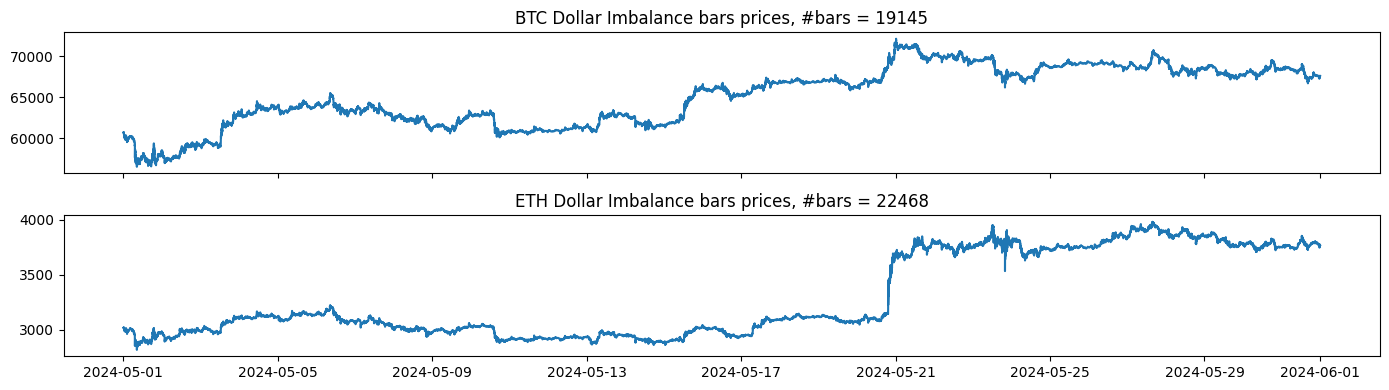

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(14, 4), sharex=True)
axs[0].plot(pd.to_datetime(btc_dollar_bar['time'], unit='ms'), btc_dollar_bar['close'])
axs[0].set_title(f"BTC Dollar Imbalance bars prices, #bars = {len(btc_dollar_bar)}")
axs[1].plot(pd.to_datetime(eth_dollar_bar['time'], unit='ms'), eth_dollar_bar['close'])
axs[1].set_title(f"ETH Dollar Imbalance bars prices, #bars = {len(eth_dollar_bar)}")

plt.tight_layout()

In [39]:
def pca_weights(cov, riskDist=None, riskTarget=1.0):
    """
    Implementation from the book
    """
    # Following the riskAlloc, distribution, match riskTarget
    eVal, eVec = np.linalg.eigh(cov)  # must be Hermitian
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1.0
    loads = riskTarget * (riskDist / eVal) ** 0.5
    weights = np.dot(eVec, np.reshape(loads, (-1, 1)))

    return weights


prices = pd.concat({
    'BTC': btc_dollar_bar['close'],
    'ETH': eth_dollar_bar['close'],
}, axis=1).iloc[:min(len(btc_dollar_bar), len(eth_dollar_bar))]
cov = prices[['BTC', 'ETH']].pct_change()[1:].cov()
# len(prices[['BTC', 'ETH']].pct_change())
weights = pca_weights(cov)
weights

array([[-1017.11398838],
       [   25.62316579]])

#### 2.3 (b) Derive the time series spread of BTC/ETH 

<Axes: >

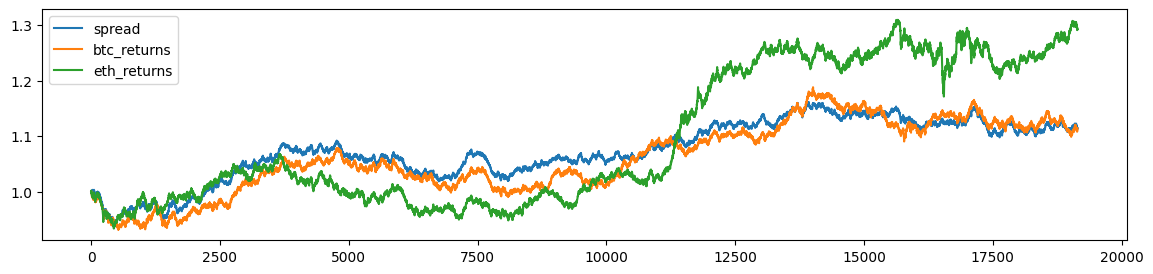

In [57]:
cov = prices[['BTC', 'ETH']].pct_change().rolling(22).cov()
fd = cov.index.levels[0]
weights = pd.Series(fd).apply(lambda x: pca_weights(cov.loc[x]))
split_w = weights.apply(lambda xx:[x[0] for x in xx]).apply(pd.Series)
xx = pd.concat([split_w])
xx.columns = cov.columns
xx = xx.add_suffix('_w')
xx = xx.div(xx.abs().sum(axis=1), axis=0).abs().fillna(0)

prices['BTC_w'] = xx['BTC_w'].values
prices['ETH_w'] = xx['ETH_w'].values
prices['spread_returns'] = prices['BTC'].pct_change() * prices['BTC_w'] + prices['ETH'].pct_change() * prices['ETH_w'] 
prices['btc_returns'] = (1 + prices['BTC'].pct_change()).cumprod() 
prices['eth_returns'] = (1 + prices['ETH'].pct_change()).cumprod() 
prices['spread'] = (1 + prices['spread_returns']).cumprod()
prices[['spread', 'btc_returns', 'eth_returns']].plot(figsize=(14,3))

#### 2.3 (c) check stationary

In [60]:
from statsmodels.tsa import stattools as stt
btc_adf = stt.adfuller(btc_dollar_bar['close'])
eth_adf = stt.adfuller(eth_dollar_bar['close'])

print("BTC dollar bars:")
print('ADF Statistic:', btc_adf[0])
print('p-value:', btc_adf[1])
print('Critical Values:', btc_adf[4])
print('Number of Lags Used:', btc_adf[2])
print('Number of Observations Used:', btc_adf[3])
if btc_adf[1] < 0.05 and btc_adf[0] < btc_adf['5%']:
    print('The btc dollar bars is stationary.')
else:
    print('The btc dollar bars is not stationary.')
    
print()
print("ETH dollar bars:")
print('ADF Statistic:', eth_adf[0])
print('p-value:', eth_adf[1])
print('Critical Values:', eth_adf[4])
print('Number of Lags Used:', eth_adf[2])
print('Number of Observations Used:', eth_adf[3])
if eth_adf[1] < 0.05 and eth_adf[0] < eth_adf['5%']:
    print('The eth dollar bars is stationary.')
else:
    print('The eth dollar bars is not stationary.')

BTC dollar bars:
ADF Statistic: -1.192373710712636
p-value: 0.6768677149658825
Critical Values: {'1%': -3.430691630643804, '5%': -2.861690988365815, '10%': -2.566850367046074}
Number of Lags Used: 0
Number of Observations Used: 19144
The btc dollar bars is not stationary.

ETH dollar bars:
ADF Statistic: -0.7965654060553699
p-value: 0.8201288722739544
Critical Values: {'1%': -3.430641134588561, '5%': -2.8616686720334177, '10%': -2.566838488472423}
Number of Lags Used: 3
Number of Observations Used: 22464
The eth dollar bars is not stationary.


In [61]:
del btc_transactions
del eth_transactions
del btc_dollar_bar
del eth_dollar_bar
gc.collect()

0

### 2.4 Form E-mini S&P 500 futures dollar bars

#### 2.4 (a) compute BB

In [124]:
# dates = ['2024-03', '2024-04', '2024-05']
# btc_transactions = reduce_memory_usage(
#     pd.concat([
#         load_df(f"Advances-In-Financial-Machine-Learning\data\BTCUSDT-trades-{date}.csv")
#         for date in dates
#     ])
# )
btc_dollar_bar = create_dollar_bars(btc_transactions, int(1e9))

Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.03 MB
Decreased by 0.0%


In [125]:
def calculate_bollinger_bands(prices, window_size=20, width=0.05):
    moving_average = prices.rolling(window=window_size).mean()
    
    upper_band = moving_average * (1 + width / 2)
    lower_band = moving_average * (1 - width / 2)
    return moving_average, upper_band, lower_band


def bb_crossings(timestamps: np.ndarray, prices: np.ndarray, upper_band: np.ndarray, lower_band: np.ndarray):
    crosses_upper = (prices[:-1] <= upper_band[:-1]) & (prices[1:] > upper_band[1:])
    crosses_lower = (prices[:-1] >= lower_band[:-1]) & (prices[1:] < lower_band[1:])
    
    return timestamps[1:][crosses_lower | crosses_upper]

In [128]:
ma, ub, lb = calculate_bollinger_bands(btc_dollar_bar['close'], window_size=100, width=0.05)

plot_data_points = int(1e5)
_btc_dollar_bar = btc_dollar_bar.iloc[:plot_data_points]
_ma, _ub, _lb = ma[:plot_data_points], ub[:plot_data_points], lb[:plot_data_points]
open_time = pd.to_datetime(_btc_dollar_bar['time'], unit='ms')

fig = go.Figure(
    data=[go.Candlestick(x=open_time, open=_btc_dollar_bar['open'],
                         high=_btc_dollar_bar['high'], low=_btc_dollar_bar['low'],
                         close=_btc_dollar_bar['close'], name='BTC Dollar Bars')]
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Dollar Bars with Bollinger Bands")
fig.add_trace(go.Scatter(x=open_time, y=_ma, line=dict(color="blue", width=1), name='MA'))
fig.add_trace(go.Scatter(x=open_time, y=_ub, line=dict(color="gray", width=1), name='Upper Band'))
fig.add_trace(go.Scatter(x=open_time, y=_lb, line=dict(color="gray", width=1), fill = 'tonexty', name='Lower Band'))
fig.show()

In [129]:
bb_crossing_events = bb_crossings(btc_dollar_bar["time"].values, btc_dollar_bar["close"].values, ub.values, lb.values)
print(f'Number of crossing ma 100 and bb 5%: {len(bb_crossing_events)} / {len(btc_dollar_bar)}')

Number of crossing ma 100 and bb 5%: 55 / 1127


#### 2.4 (b) cumsum on returns

In [130]:
btc_dollar_bar_returns = returns(btc_dollar_bar['close'])

In [139]:
from numba_implementations import getTEvents


cumsum_events = getTEvents(btc_dollar_bar['time'][1:].values, btc_dollar_bar_returns.values, 0.025)
print(f'Number of crossing cumsum filter with h = 0.0066: {len(cumsum_events)} / {len(btc_dollar_bar)}')

Number of crossing cumsum filter with h = 0.0066: 165 / 1127


#### 2.4 (c) rolling variance the events

<Axes: title={'center': 'Bolling Band Crossing events'}>

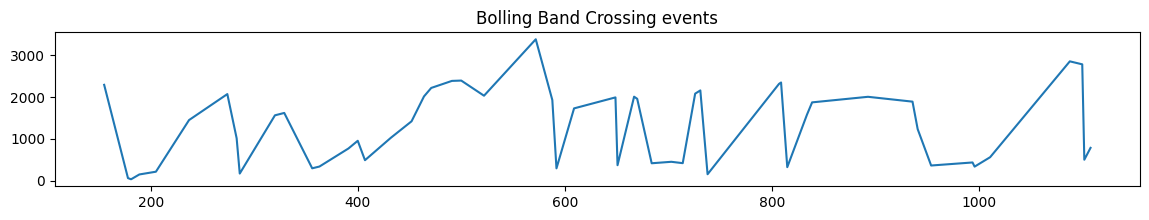

In [134]:
btc_dollar_bar[btc_dollar_bar['time'].isin(bb_crossing_events)]['close'].rolling(3).std().plot(title='Bolling Band Crossing events', figsize=(14, 2))

<Axes: title={'center': 'CUMSUM Filter events'}>

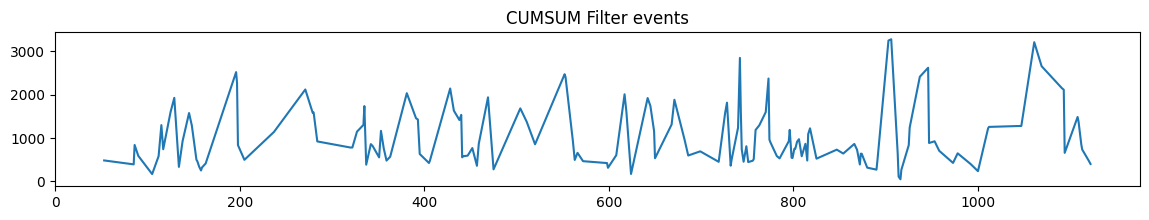

In [140]:
btc_dollar_bar[btc_dollar_bar['time'].isin(cumsum_events)]['close'].rolling(3).std().plot(title='CUMSUM Filter events', figsize=(14, 2))

### 2.5 absolute cumsum filter

In [141]:
abs_cumsum_events = getTEvents(btc_dollar_bar['time'][1:].values, np.abs(btc_dollar_bar_returns.values), 0.025)
print(f'Number of crossing cumsum filter with h = 0.01: {len(abs_cumsum_events)} / {len(btc_dollar_bar)}')

Number of crossing cumsum filter with h = 0.01: 13 / 1127


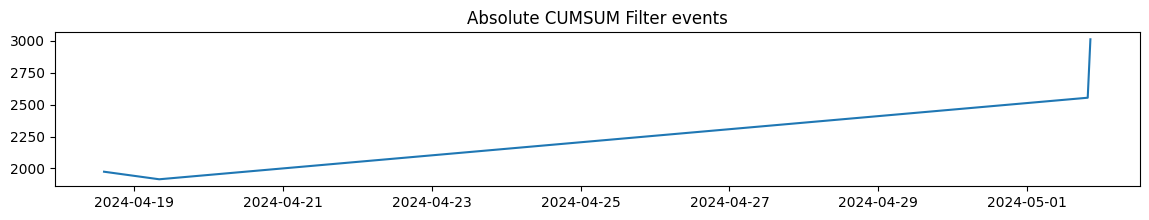

In [142]:
plt.figure(figsize=(14, 2))
plt.title('Absolute CUMSUM Filter events')
plt.plot(pd.to_datetime(abs_cumsum_events, unit='ms'),
         btc_dollar_bar[btc_dollar_bar['time'].isin(abs_cumsum_events)]['close'].rolling(10).std()
         )

In [143]:
def scatter_events_on_plot(bars: pd.DataFrame, events: np.ndarray, events_title: str):
    open_time = pd.to_datetime(bars['time'], unit='ms')
    fig = go.Figure(
        data=[go.Scatter(x=open_time, y=bars['close'], line=dict(color="blue", width=1), name='price')]
    ).update_layout(xaxis_title="Time", yaxis_title="Price", title="Dollar Bars")
    event_time = pd.to_datetime(events, unit='ms')
    fig.add_trace(go.Scatter(x=event_time, y=bars[bars['time'].isin(events)]['close'], mode='markers', name=events_title))
    fig.show()


scatter_events_on_plot(btc_dollar_bar, bb_crossing_events, events_title='bollinger band filter')
scatter_events_on_plot(btc_dollar_bar, cumsum_events, events_title='cumsum filter')
scatter_events_on_plot(btc_dollar_bar, abs_cumsum_events, events_title='abs cumsum filter')